In [32]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import import_data

In [33]:
# load the dataset
dataframe = import_data.import_data('./hackathon_data/*20*.dat', index_col_val='date_' , parse_dates='date_', date_format='%Y%m%d')
cols = dataframe.columns.tolist()
cols = cols[-3:] + cols[:-3]
dataframe = dataframe[cols]
print(dataframe.head(5))
dataframe.to_csv('./hackathon_data/test_data.dat')

            quantity  on_promotion  promotion_type  store  department    item  \
date_                                                                           
2009-01-02      12.0             0               0    315           2    8598   
2009-01-02      15.0             0               0    315           2   22631   
2009-01-02       9.0             0               0    315           2  102257   
2009-01-02       6.0             0               0    315           2  263929   
2009-01-02       6.0             0               0    315           2  423218   

            unit_price  
date_                   
2009-01-02        5.61  
2009-01-02       11.88  
2009-01-02        9.21  
2009-01-02       16.11  
2009-01-02       14.91  


            quantity  on_promotion  promotion_type  store  department    item  \
date_                                                                           
2009-01-02      12.0             0               0    315           2    8598   
2009-01-02      15.0             0               0    315           2   22631   
2009-01-02       9.0             0               0    315           2  102257   
2009-01-02       6.0             0               0    315           2  263929   
2009-01-02       6.0             0               0    315           2  423218   

            unit_price  
date_                   
2009-01-02        5.61  
2009-01-02       11.88  
2009-01-02        9.21  
2009-01-02       16.11  
2009-01-02       14.91  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1351071 entries, 2009-01-02 to 2011-12-31
Data columns (total 7 columns):
quantity          1351071 non-null float64
on_promotion      1351071 non-null int64
promotion_type    1351071 non-null int64
store

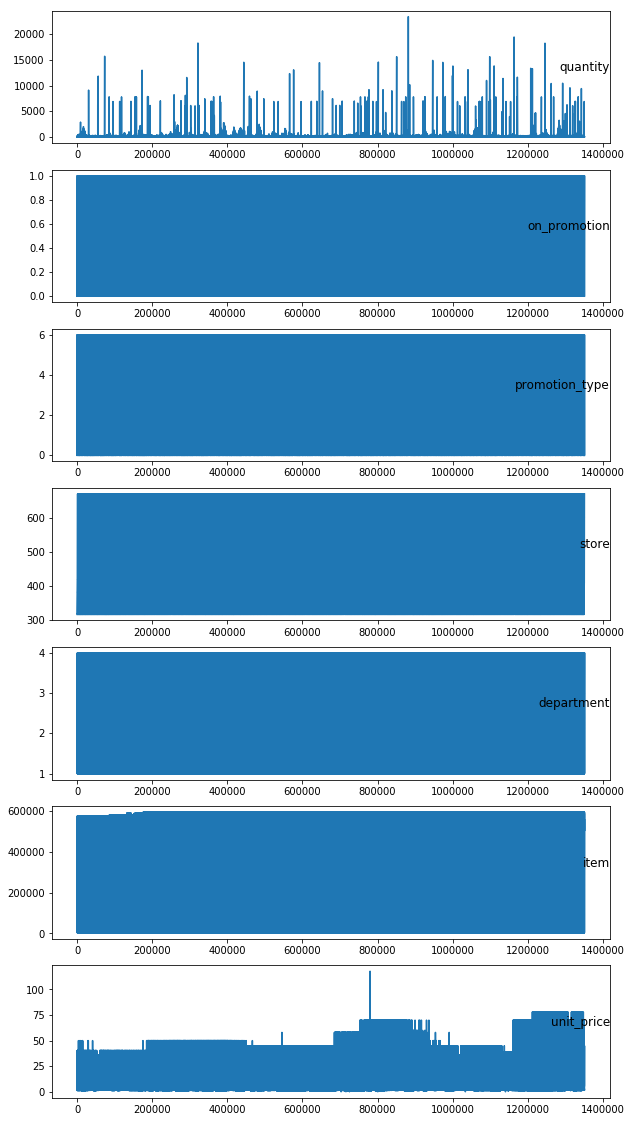

In [34]:
from pandas import read_csv
from matplotlib import pyplot
import matplotlib as mpl
# load dataset
dataset = read_csv('./hackathon_data/test_data.dat', header=0, index_col=0, parse_dates=['date_'])
print(dataset.head(5))
dataset.info()
values= dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5, 6]
i = 1
# plot each column
mpl.rcParams['figure.figsize'] = (10,20)
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [137]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
# load dataset
dataset = read_csv('./hackathon_data/test_data.dat', header=0, index_col=0)
values = dataset.values
print(values[:,0])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 3
n_features = 7
n_out = 2
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, n_out)
# drop columns we don't want to predict
for i in range(0, n_out):
    reframed.drop(reframed.columns[[(n_hours*n_features+1), 
                                    (n_hours*n_features+2), 
                                    (n_hours*n_features+3), 
                                    (n_hours*n_features+4), 
                                    (n_hours*n_features+5), 
                                    (n_hours*n_features+6)]],
                  axis=1, inplace=True)
print(reframed.head())
print(reframed.shape)

[12.  15.   9.  ... 22.5  1.5  4.5]
   var1(t-3)  var2(t-3)  var3(t-3)  var4(t-3)  var5(t-3)  var6(t-3)  \
3   0.000449        0.0        0.0        0.0   0.333333   0.008338   
4   0.000578        0.0        0.0        0.0   0.333333   0.032143   
5   0.000321        0.0        0.0        0.0   0.333333   0.167220   
6   0.000193        0.0        0.0        0.0   0.333333   0.441478   
7   0.000193        0.0        0.0        0.0   0.333333   0.711694   

   var7(t-3)  var1(t-2)  var2(t-2)  var3(t-2)    ...      var7(t-2)  \
3   0.047482   0.000578        0.0        0.0    ...       0.100739   
4   0.100739   0.000321        0.0        0.0    ...       0.078060   
5   0.078060   0.000193        0.0        0.0    ...       0.136669   
6   0.136669   0.000193        0.0        0.0    ...       0.126476   
7   0.126476   0.000193        0.0        0.0    ...       0.126476   

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
3   0.000321        0.0        0.0     

In [138]:
# split into train and test sets
values = reframed.values
# print(values.size)
n_train_days = 365 * 1074 * 2
train = values[:n_train_days, :]
test = values[n_train_days:,:]
# print(test)
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:,:n_obs], train[:, -n_out]
test_X, test_y = test[:, :n_obs], test[:, -n_out]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(784020, 21) 784020 (784020,)
(784020, 3, 7) (784020,) (567047, 3, 7) (567047,)


In [129]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

Train on 784020 samples, validate on 567047 samples
Epoch 1/50
 - 7s - loss: 7.1683e-04 - val_loss: 7.4490e-04
Epoch 2/50
 - 7s - loss: 7.1395e-04 - val_loss: 6.8437e-04
Epoch 3/50
 - 7s - loss: 6.9864e-04 - val_loss: 6.9431e-04
Epoch 4/50
 - 7s - loss: 6.9132e-04 - val_loss: 6.8855e-04
Epoch 5/50
 - 7s - loss: 6.9940e-04 - val_loss: 6.5945e-04
Epoch 6/50
 - 7s - loss: 6.8141e-04 - val_loss: 8.1589e-04
Epoch 7/50
 - 7s - loss: 6.9328e-04 - val_loss: 7.7190e-04
Epoch 8/50
 - 7s - loss: 6.8943e-04 - val_loss: 7.2682e-04
Epoch 9/50
 - 7s - loss: 6.7290e-04 - val_loss: 6.5649e-04
Epoch 10/50
 - 7s - loss: 6.7872e-04 - val_loss: 6.4865e-04
Epoch 11/50
 - 7s - loss: 6.7315e-04 - val_loss: 7.6946e-04
Epoch 12/50
 - 7s - loss: 6.7973e-04 - val_loss: 6.5158e-04
Epoch 13/50
 - 7s - loss: 6.6614e-04 - val_loss: 6.4219e-04
Epoch 14/50
 - 7s - loss: 6.6854e-04 - val_loss: 6.6714e-04
Epoch 15/50
 - 7s - loss: 6.6025e-04 - val_loss: 6.5446e-04
Epoch 16/50
 - 7s - loss: 6.6744e-04 - val_loss: 6.6333e-

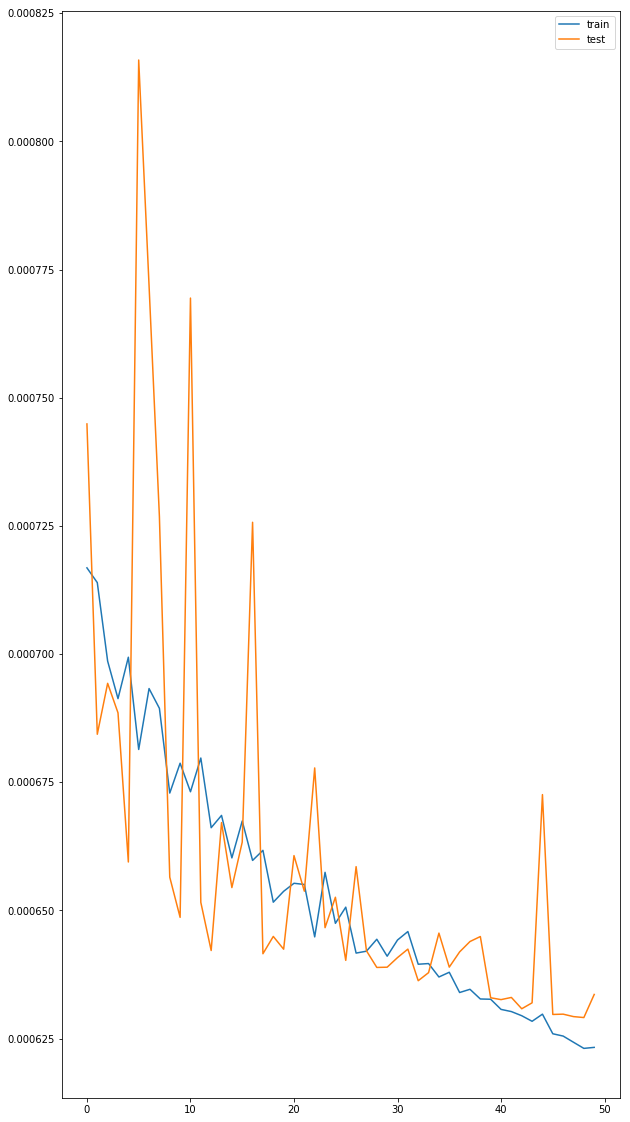

In [145]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=1074, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [143]:
# test prediction accuracy
yhat = model.predict(test_X)

In [144]:
test_X_2 = test_X.reshape((test_X.shape[0], 21))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X_2[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X_2[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 116.728


In [60]:
# make a prediction
test_data = import_data.import_data('./hackathon_data/*_result.dat', index_col_val='date_' , parse_dates='date_', date_format='%Y%m%d')
cols = test_data.columns.tolist()
cols = cols[-3:] + cols[:-3]
test_data = test_data[cols]
print(test_data.head(5))
test_values = test.values

            quantity  on_promotion  promotion_type  store  department    item  \
date_                                                                           
2012-01-02       NaN             0               0    315           1   95470   
2012-01-02       NaN             0               0    315           1  507566   
2012-01-02       NaN             0               0    315           1  593171   
2012-01-02       NaN             0               0    315           2   22631   
2012-01-02       NaN             0               0    315           2  404470   

            unit_price  
date_                   
2012-01-02       10.00  
2012-01-02       10.00  
2012-01-02       10.00  
2012-01-02       12.84  
2012-01-02       12.54  
